## Input data

In [1]:
graph_path = "networks/flsaclr+1.graphml" #the path of the graph
fasta_path = "sequences_mariarita.fasta" #fasta file. if no just let the "" empty
excel_path = "" #excel file. if no just let the "" empty
output_path = "outputs/mariarita_lsa.pdf" #path of your output with the extension.pd

## Computation

In [2]:
#%matplotlib notebook
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.backends.backend_pdf
from Bio import SeqIO
import re
from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 300

In [3]:
norm_df = pd.read_csv("useful_tables/norm_abundances.tsv",sep="\t",index_col=0)
df_niches_asv = pd.read_csv("useful_tables/ASVs_metavars.tsv",sep="\t",index_col = 0)
df_niches_seasons = pd.read_csv("useful_tables/seasons_metavars.tsv",sep="\t",index_col = 0)

In [4]:
norm_df.index = pd.DatetimeIndex(norm_df.index)
header = ["1_Q2","2_Q2","3_Q2","4_Q2"]
df_niches_asv = df_niches_asv[header]
df_niches_asv.columns = ["1","2","3","4"]

In [5]:
if fasta_path != "":
    drecord = dict()
    with open(fasta_path,"r") as handle:
        for record in SeqIO.parse(handle, "fasta"):
            drecord[record.id]=str(record.seq)
    fasta = pd.DataFrame(drecord.keys())
G = nx.read_graphml(graph_path)
#Excel file with list of nodes/correlations
if excel_path != "":
    req = pd.read_csv(excel_path,sep="\t",header=None)
pdf = matplotlib.backends.backend_pdf.PdfPages(output_path)

In [6]:
def match_kw_node(G,kw1):
    matches = list()
    for n,d in G.nodes(data=True):
        tax = d["taxonomy"]
        if re.findall(kw1,tax):
            nodes=[n]
            nodes.extend(list(nx.neighbors(G,n)))
            matches.append(nodes)
    return(matches)

def match_kw_edge(G,kw1,kw2):
    matches = list()
    nodes = G.nodes()
    for n1 in nodes:
        d1 = G.nodes[n1]
        tax1 = d1["taxonomy"]
        if re.findall(kw1,tax1):
            connected = [ e[1] for e in G.edges(n1)]
            for n2 in connected:
                tax2 = G.nodes[n2]["taxonomy"]
                if re.findall(kw2,tax2):
                    d2 = G.nodes[n2]
                    matches.append([n1,n2])
    return(matches)

def mycolormap(index=None):
    colors = ["#6D93EE","#E01D22","#FABD28","#96AF00",
    "#804DFF","#FF7749","#47240F","#4CCDA4","#B60085",
    "#3B9A3C","#2B5985","#FF429B","#5FFFF8","#20FC86",
    "#9600A5","#B1E7FF","#80FF00","#6B4C81","#989898",
    "#0F7C6A","#BB4C71",'#B4FF9B',"#EAD788","#FFC6F6",
    "#FF00C2","#E2A4FF","#FF4A00","#800037","#1F45FF"]*5
    if index == None:
        return colors
    else:
        return(colors[index])

def print_metaniches(list_nodes,df_niches_asv,df_niches_seasons,fig=None,ax=None):
    
    if fig==None:
        fig=plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        
    # metaniches representation #
    df_niches_asv = df_niches_seasons.append(df_niches_asv.loc[list_nodes])

    # Move left y-axis and bottim x-axis to centre, passing through (0,0)
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')
    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    #minimum and maximum
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    #graduation
    ax.xaxis.set_ticks(np.arange(-1,1.25,0.5))
    ax.yaxis.set_ticks(np.arange(-1,1.25,0.5))

    #data
    xall = list()
    yall = list()
    for i in range(0,df_niches_asv.shape[0]):
        xall.append([0,-df_niches_asv.at[df_niches_asv.index[i],df_niches_asv.columns[1]],0,df_niches_asv.at[df_niches_asv.index[i],df_niches_asv.columns[3]],0])

        yall.append( [df_niches_asv.at[df_niches_asv.index[i],df_niches_asv.columns[0]],0,-df_niches_asv.at[df_niches_asv.index[i],df_niches_asv.columns[2]],0,df_niches_asv.at[df_niches_asv.index[i],df_niches_asv.columns[0]]])

    #plot
    colors=["green","magenta","orange","turquoise"]
    for i in range(0,4):
        plt.fill(xall[i],yall[i],color=colors[i],alpha=0.15)

    for i in range(0+4,len(xall)):
        plt.plot(xall[i],yall[i],'-o',color=mycolormap(i-4))

    #legend
    legend_dict = { 'Spring' : 'green', 'Summer' : 'magenta', 'Autumn' : 'orange', "Winter": "turquoise" }
    patchList = []
    for key in legend_dict:
            data_key = mpatches.Patch(color=legend_dict[key], label=key,alpha=0.15)
            patchList.append(data_key)
    legend1 = plt.legend(handles=patchList)
    #ax.add_artist(legend1)
    #plt.legend(df_niches_asv.index[4:],loc="lower right")

In [7]:
if excel_path != "":
    lnodes=list()
    for row in req.values:
        nodes=list()
        asv1,asv2=row[0],row[1]
        if not pd.isna(asv1) and not pd.isna(asv2): #both
            if asv1 not in G.nodes and asv2 not in G.nodes: #taxonomy
                nodes = match_kw_edge(G,asv1,asv2)
                lnodes.extend(nodes)

            else:
                nodes = [asv1,asv2]
                lnodes.append(nodes)

        elif not pd.isna(asv1) and pd.isna(asv2): # one
            if asv1 not in G.nodes and asv2 not in G.nodes:
                nodes = match_kw_node(G,asv1)
                lnodes.extend(nodes)

            else:
                nodes.append(asv1)
                nodes.extend(list(nx.neighbors(G,asv1)))
                lnodes.append(nodes)

### Fasta - Network Matches

In [8]:
matches = pd.DataFrame(columns=["label","id fasta","taxonomy","reference"])

if fasta_path != "":
    lnodes = list()
    for row in fasta.values:
        nodes=list()
        asv1 = row[0]
        seq1 = drecord[asv1]
        for n,d in G.nodes(data=True):
            if seq1 in d["sequence"] or d["sequence"] in seq1:
                if n not in list(matches["label"]):
                    match = pd.Series(data={"id fasta":asv1,"label":n,"taxonomy":d["taxonomy"],"reference":d["silvareferences"]})
                    matches = matches.append(match,ignore_index=True)
                    nodes.append(n)
                    nodes.extend(list(nx.neighbors(G,n)))
                    lnodes.append(list(set(nodes)))
                    

matches.style.set_properties(**{'text-align': 'left'})
display(matches)

,label,id fasta,taxonomy,reference
0,8184_02,3,Eukaryota|SAR|Rhizaria|Cercozoa|Thecofilosea|Cryomonadida|Protaspidae|Cryothecomonas|uncultured_Rhizaria,KC488576.1.1719
1,8184_3,3,Eukaryota|SAR|Rhizaria|Cercozoa|Thecofilosea|Cryomonadida|Protaspidae|Cryothecomonas|uncultured_Rhizaria,KC488576.1.1719
2,2313_02,5,Eukaryota|Cryptophyceae|Cryptomonadales|Teleaulax|uncultured_eukaryote,KJ763648.1.1765
3,2313_3,5,Eukaryota|Cryptophyceae|Cryptomonadales|Teleaulax|uncultured_eukaryote,KJ763648.1.1765
4,1987_02,6,Eukaryota|SAR|Alveolata,"KJ757775.1.1801,KJ757790.1.1801,KJ757836.1.1799,KJ757874.1.1801,KJ757893.1.1796,KJ757977.1.1800,KJ758030.1.1798,KJ758048.1.1792,KJ758101.1.1793,KJ758174.1.1799,KJ758221.1.1803,KJ758266.1.1799,KJ758340.1.1800,KJ758351.1.1801,KJ758371.1.1801,KJ758381.1.1800,KJ758393.1.1797,KJ759460.1.1796"
5,1987_3,6,Eukaryota|SAR|Alveolata,"KJ757775.1.1801,KJ757790.1.1801,KJ757836.1.1799,KJ757874.1.1801,KJ757893.1.1796,KJ757977.1.1800,KJ758030.1.1798,KJ758048.1.1792,KJ758101.1.1793,KJ758174.1.1799,KJ758221.1.1803,KJ758266.1.1799,KJ758340.1.1800,KJ758351.1.1801,KJ758371.1.1801,KJ758381.1.1800,KJ758393.1.1797,KJ759460.1.1796"
6,3098_02,7,Eukaryota|SAR|Alveolata,"JN832834.1.1686,KJ757938.1.1800,KJ758045.1.1797,KJ758468.1.1796,KJ925439.1.1500"
7,3098_3,7,Eukaryota|SAR|Alveolata,"JN832834.1.1686,KJ757938.1.1800,KJ758045.1.1797,KJ758468.1.1796,KJ925439.1.1500"
8,8779_3,11,Eukaryota|SAR|Stramenopiles|Ochrophyta|Diatomea|Coscinodiscophytina|Rhizosolenids|Guinardia|Rhizosolenia_setigera,M87329.22.1773
9,8779_02,11,Eukaryota|SAR|Stramenopiles|Ochrophyta|Diatomea|Coscinodiscophytina|Rhizosolenids|Guinardia|Rhizosolenia_setigera,M87329.22.1773


### Results

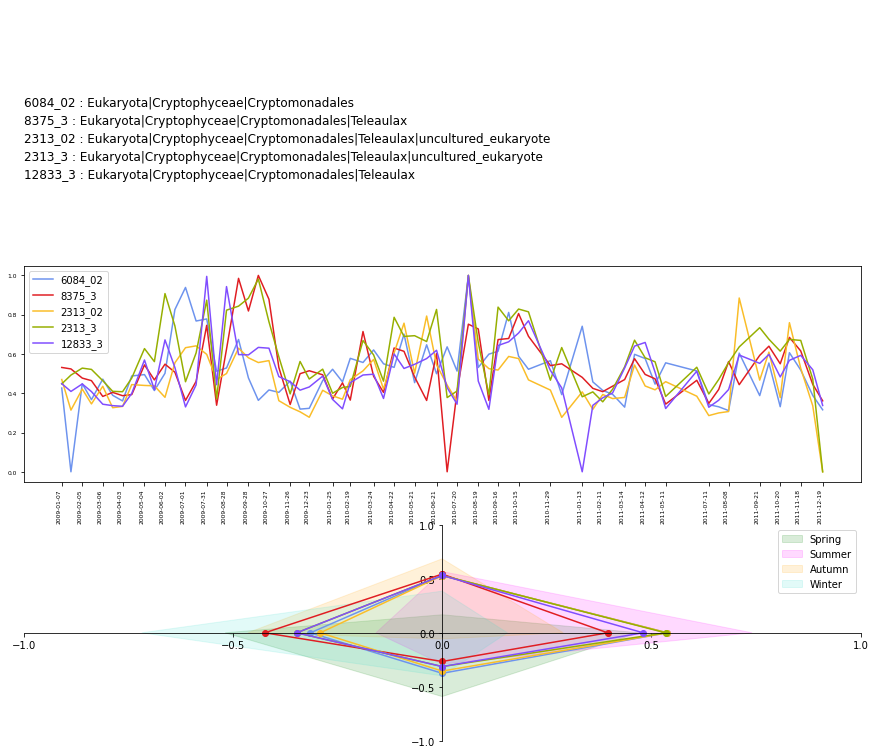

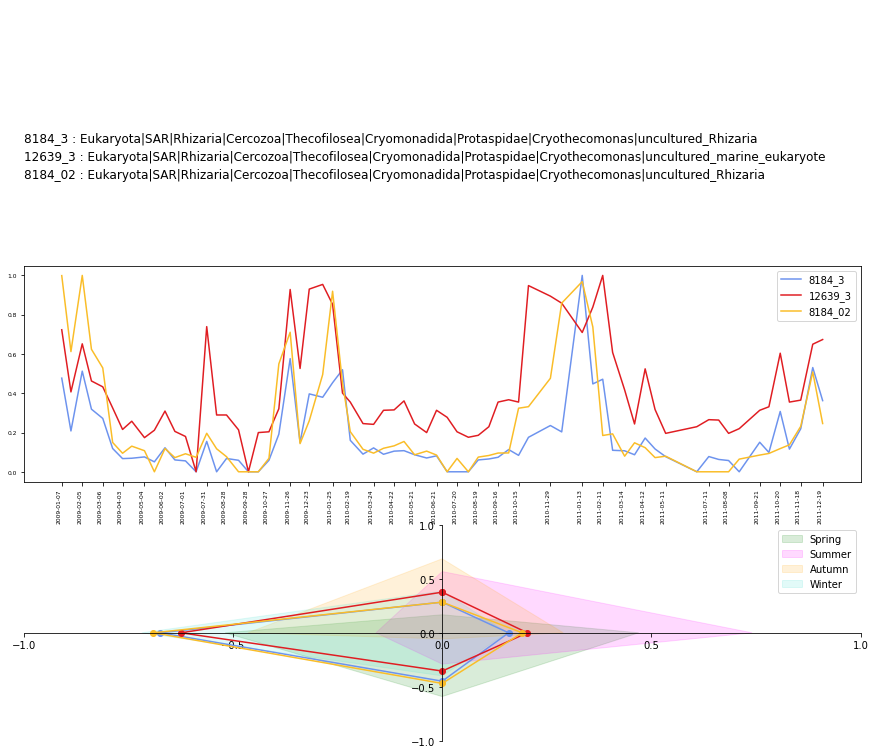

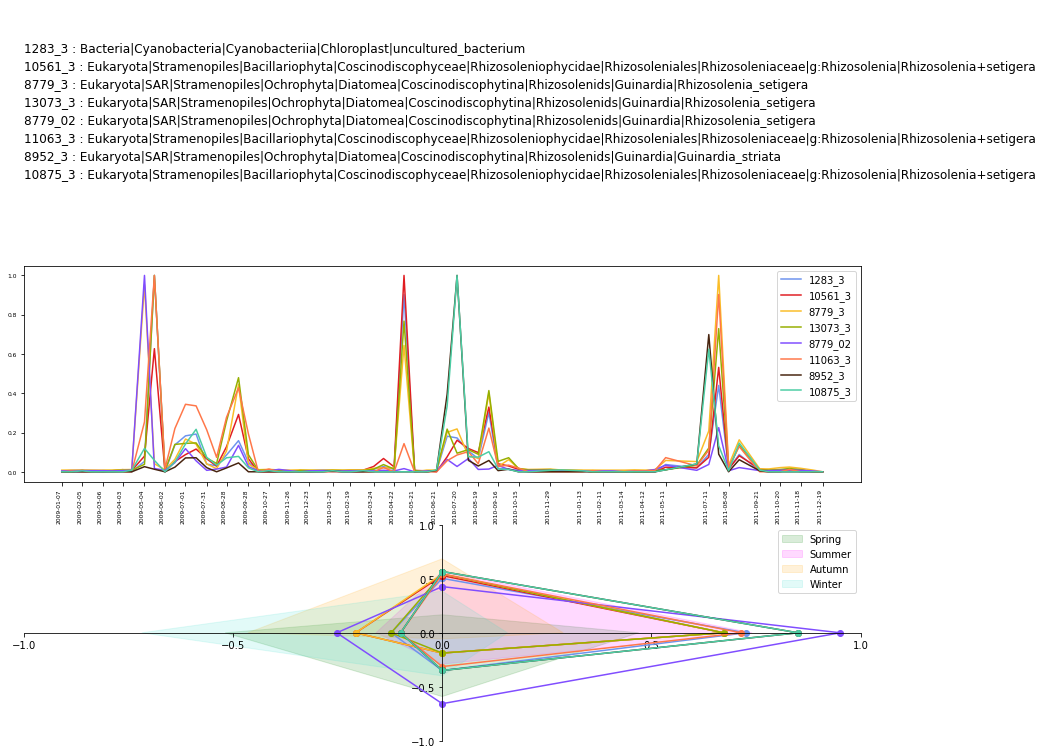

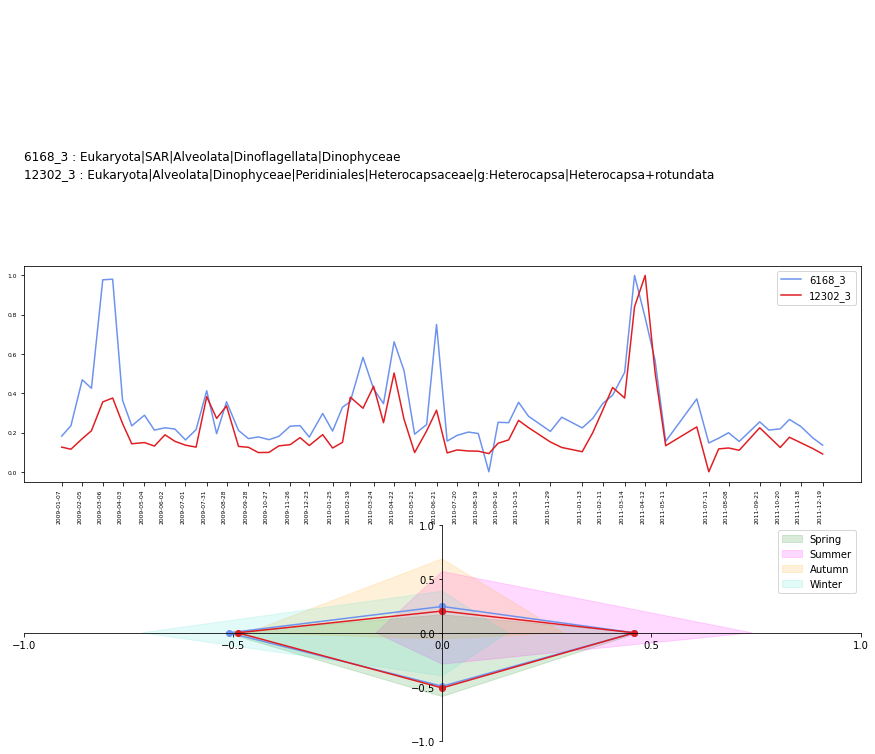

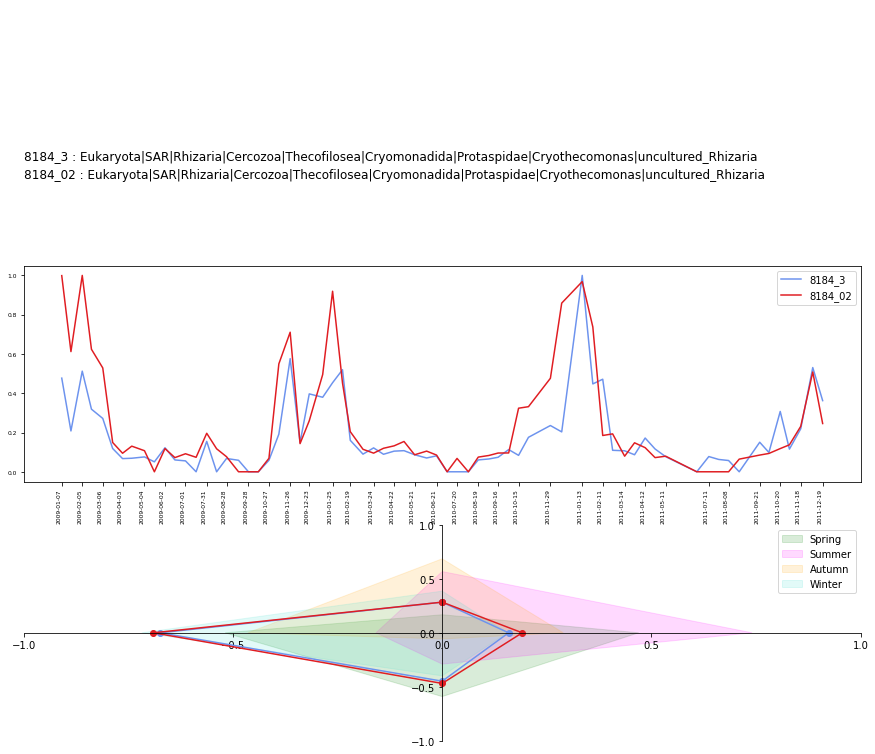

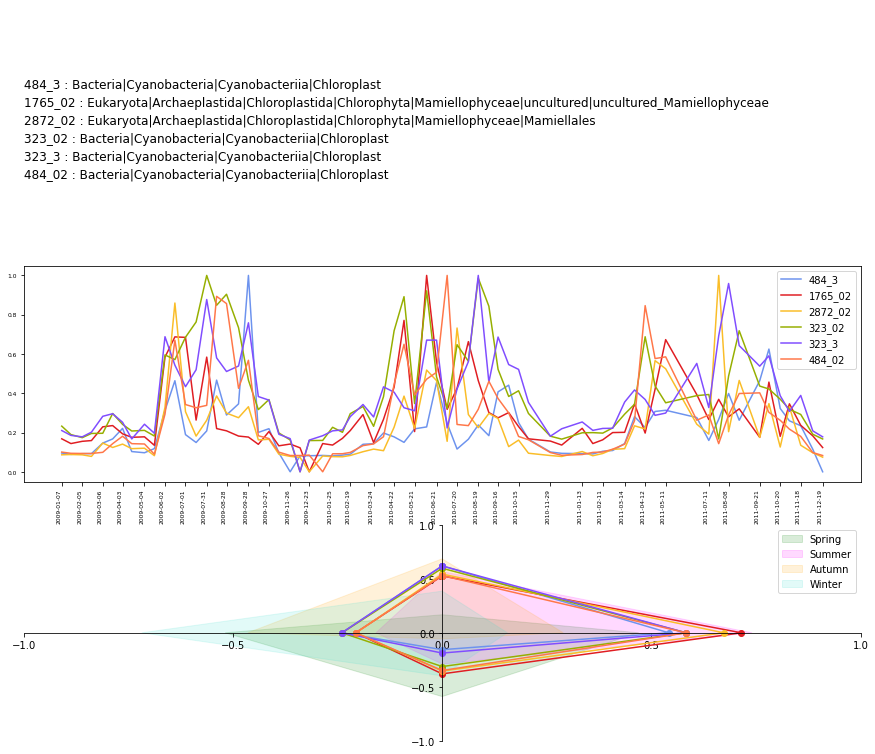

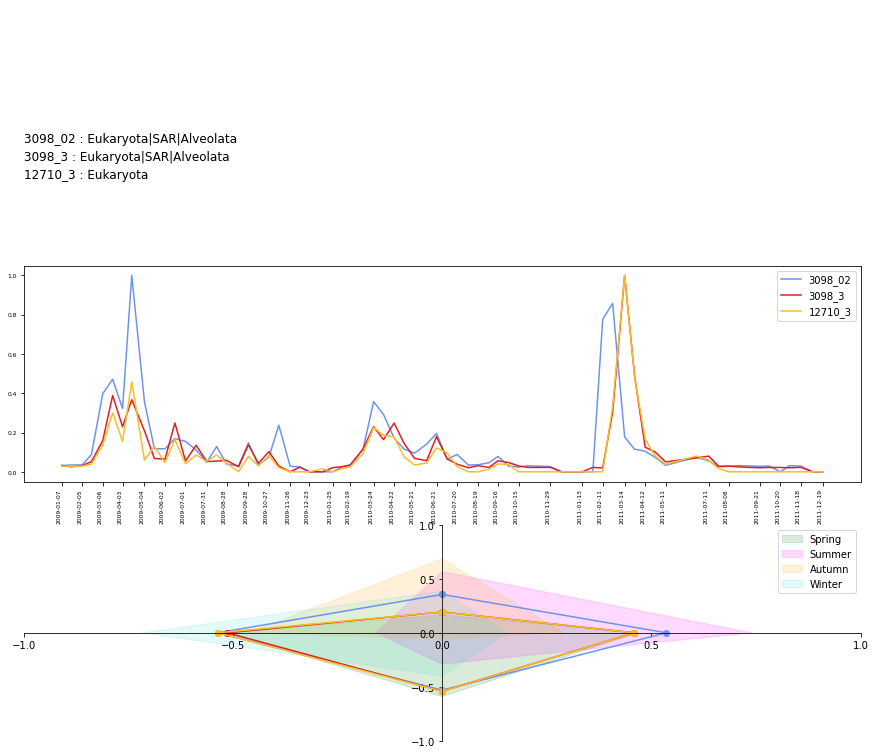

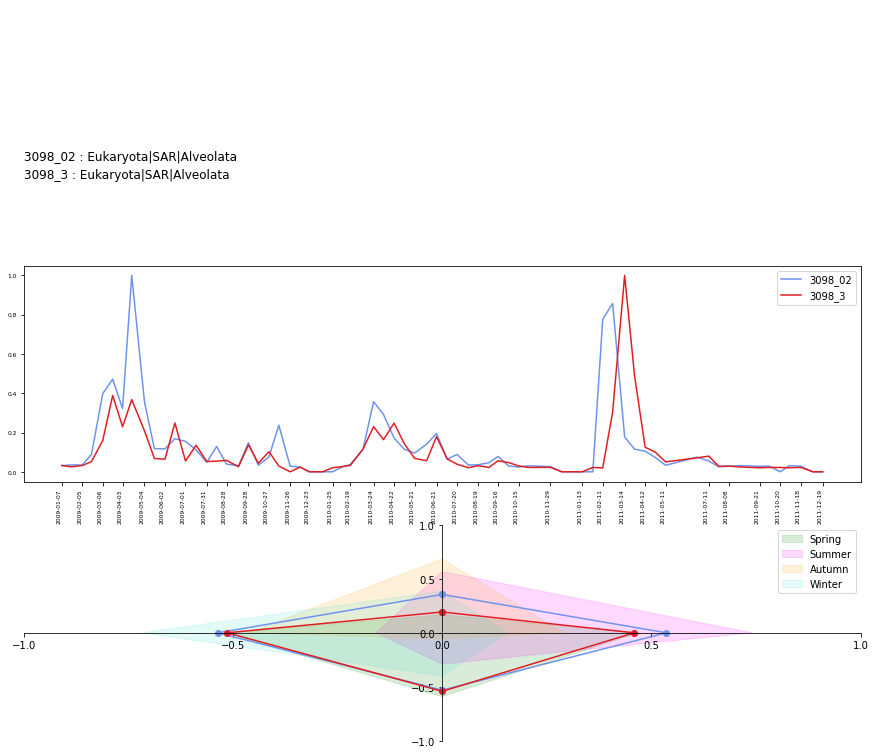

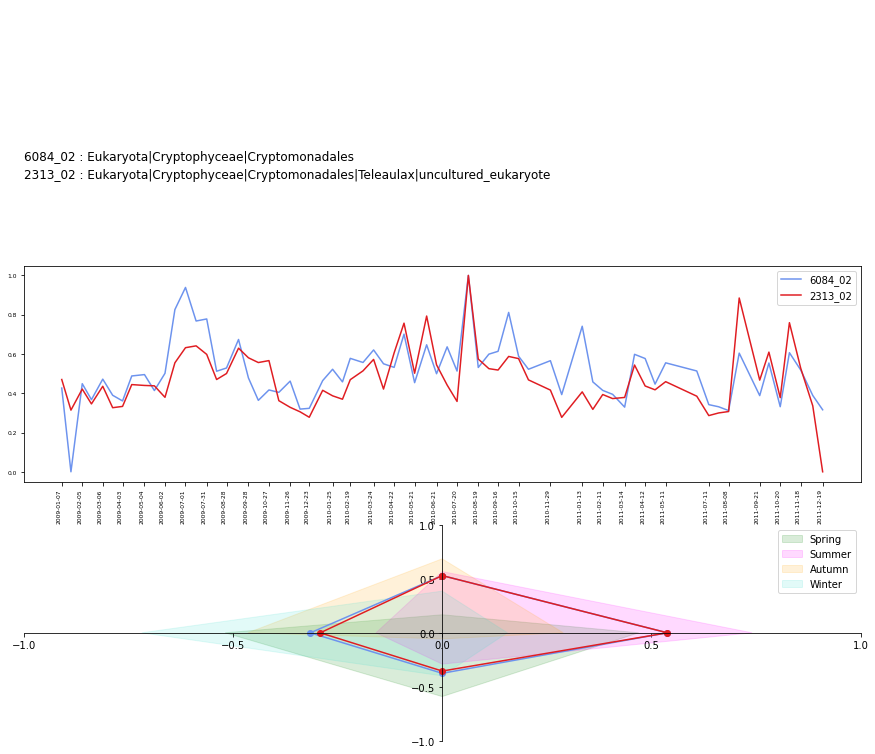

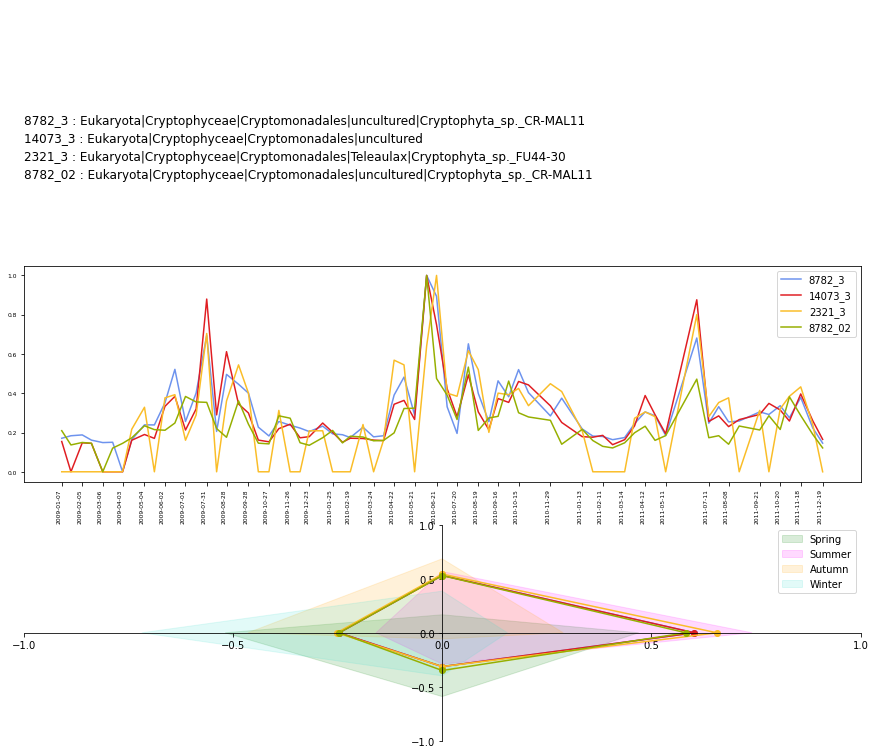

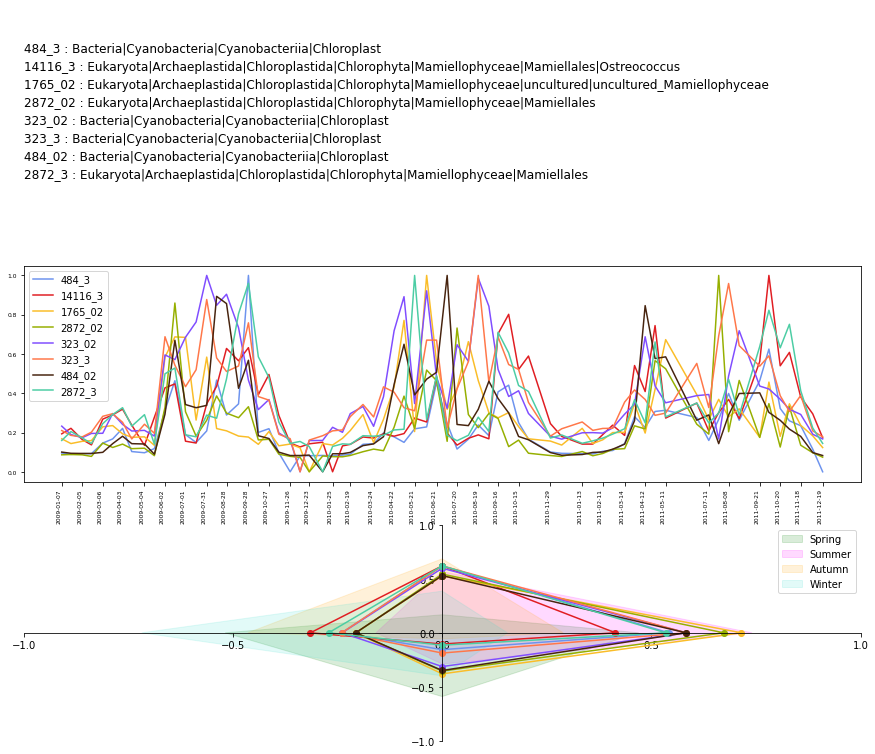

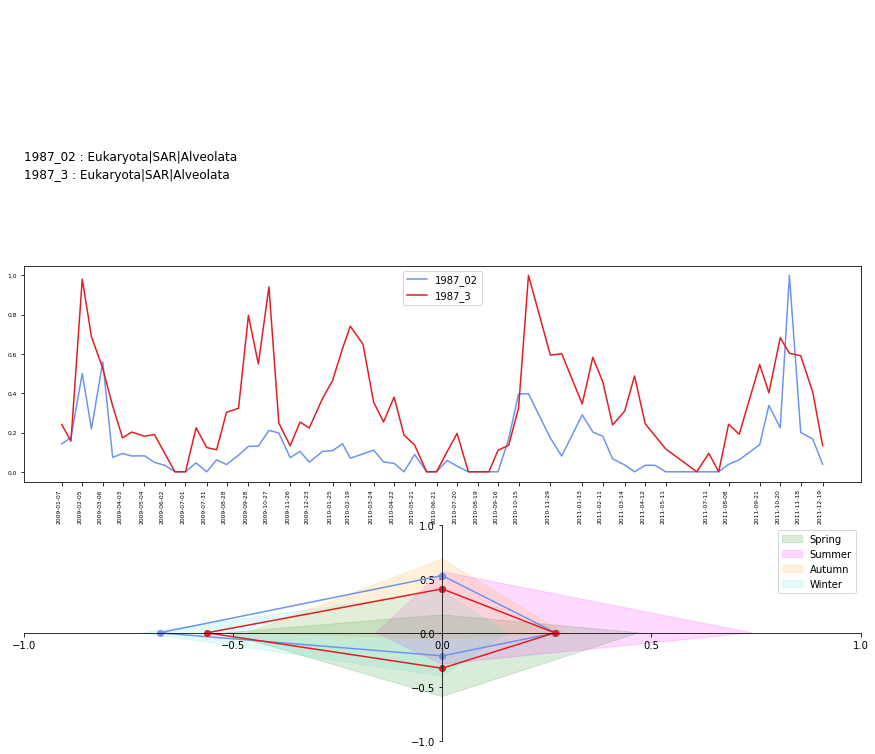

In [9]:
lnodes = set(tuple(row) for row in lnodes)
lnodes = [list(row) for row in lnodes]
for nodes in lnodes:
    fig = plt.figure(figsize=(15,15))
    ax1 = fig.add_subplot(312)
    norm_df[nodes].plot(kind="line",xticks = list(norm_df.index)[::2],rot=90,fontsize=6,ax=ax1,color=mycolormap())
    ax2  = fig.add_subplot(313)
    print_metaniches(nodes,df_niches_asv,df_niches_seasons,fig,ax2)
    ax3 = fig.add_subplot(211)
    ax3.axis("off")
    text = ("\n").join([n+" : "+G.nodes[n]["taxonomy"] for n in nodes])
    plt.text(0,0.5,text,wrap=True,linespacing = 1.5,fontsize=12)
    pdf.savefig(fig)
pdf.close()